In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
def accuracy_plot(model, title): 
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def loss_plot(model, title): 
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# plotting

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def confusion_plot(y_true_labels, y_pred_labels, title, class_names): 

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("All data confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=title)

    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=title)

    plt.show()

In [3]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [4]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [5]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    encoded_seq = np.argmax((one_hot_seq), axis=1) 
    return encoded_seq
    #return pd.get_dummies(
      #list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)

In [6]:
alph_len = len(new_alph)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [7]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD
from keras.regularizers import l2

def embed_model(embed_dim, hidden_layers, l2_coeff, dropout_rate):
    X_in = Input(shape=(seq_len,),dtype='float32')
    E = Embedding(alph_len,embed_dim,input_length=seq_len)(X_in)
    H = Flatten()(E)
    H = Dropout(dropout_rate)(H)
    for h in hidden_layers: 
        H = Dense(h, activation='relu', activity_regularizer = l2(l2_coeff))(H)
        H = Dropout(dropout_rate)(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model

In [8]:
model = embed_model(embed_dim=5, hidden_layers=(50,), l2_coeff = 0.001, dropout_rate = 0.0)

X = train_data
y = train_bins
num_epochs = 20
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
initial_loss, initial_accuracy = model.evaluate(X, y)
print("Epoch 0: Loss ", initial_loss, " accuracy ", initial_accuracy)
model.fit(X, y, epochs=num_epochs, batch_size=128)#,validation_data=(val_data, val_bins))#,callbacks=[early_stopping])

327078/327078 [==============================] - 3s 9us/step
Epoch 0: Loss  0.6761063544646078  accuracy  0.9002623227483377
Epoch 1/20
327078/327078 [==============================] - 3s 8us/step - loss: 0.0715 - acc: 0.9982
Epoch 2/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0188 - acc: 0.9983A: 1s
Epoch 3/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0098 - acc: 0.9987
Epoch 4/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0070 - acc: 0.9987A: 0s - loss: 0.0072 -
Epoch 5/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0060 - acc: 0.9987
Epoch 6/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0056 - acc: 0.9988
Epoch 7/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0053 - acc: 0.9988
Epoch 8/20
327078/327078 [==============================] - 2s 7us/step - loss: 0.0051 - acc: 0.9988
Epoch 9/20
327078/327078 [==============

AUC: 0.7615506490777929
Accuracy: 0.998584053513012 

F1: 0.8023664654973843 

Confusion matrix, without normalization
[[81719    35]
 [   81    89]]


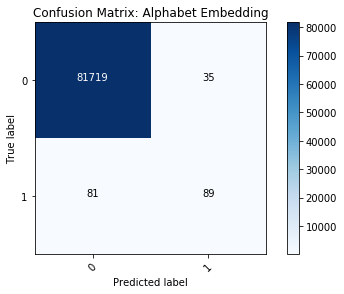

All data confusion matrix
[[1.00e+00 4.28e-04]
 [4.76e-01 5.24e-01]]


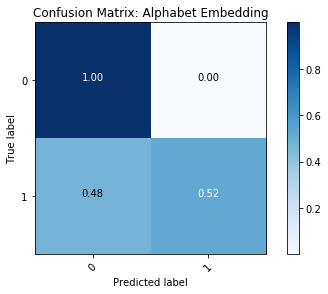

Average precision-recall score: 0.84


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

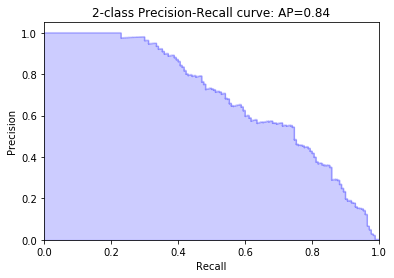

In [9]:
specs = 'Alphabet Embedding'

X_new = test_data
y_true = test_bins
y_pred = model.predict(X_new)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1) 
from sklearn.metrics import roc_auc_score

print('AUC:', roc_auc_score(y_true_labels, y_pred_labels))

print('Accuracy:', sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels), '\n')
print('F1:', sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

#accuracy_plot(model, 'Accuracy: ' + specs)
#loss_plot(model, 'Loss: ' + specs)

class_names = ['0', '1']
confusion_plot(y_true_labels, y_pred_labels, 'Confusion Matrix: ' + specs, class_names)

# from TAs on piazza: use precision-recall, ROC can be misleading 
# modified code from sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# and referenced: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true_labels, y_pred[:,1]) # look at positive class prob

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

[<keras.engine.input_layer.InputLayer object at 0x129e67048>, <keras.layers.embeddings.Embedding object at 0x129e670b8>, <keras.layers.core.Flatten object at 0x129e67160>, <keras.layers.core.Dropout object at 0x129e67198>, <keras.layers.core.Dense object at 0x129e671d0>, <keras.layers.core.Dropout object at 0x129e672b0>, <keras.layers.core.Dense object at 0x129e67470>]


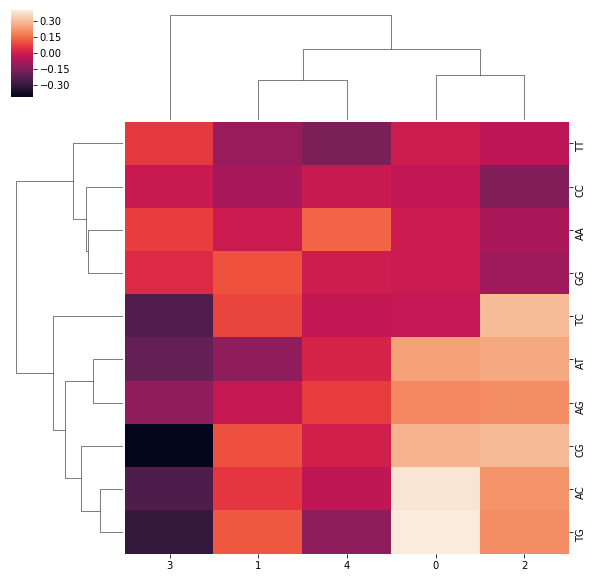

In [31]:
# look at the learned weights to viz embedding of new alphabet
weight_matrix = model.layers[1].get_weights()[0]
weights = pd.DataFrame(weight_matrix)
print(model.layers)
import seaborn as sns
reverse_map = {v:k for k,v in new_alph_map.items()}
sns.clustermap(weights,yticklabels=[reverse_map[letter] for letter in new_alph])

Text(0.5, 1.0, 'PCA over Learned Embedding Weights')

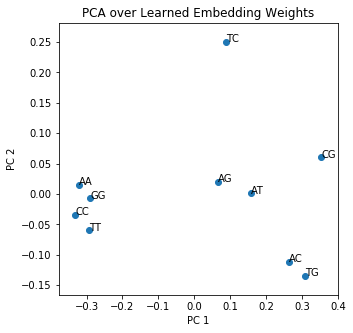

In [34]:
# pca - code: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 
from sklearn.decomposition import PCA

X = weights

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])

# display PCA for positions -- do certain positions cluster together 
# NOTE: this is embedded space (like word2vec for base positions)
plt.scatter(principalDf['PC 1'], principalDf['PC 2'])
labels = [reverse_map[letter] for letter in new_alph]#[str(pos_i) for pos_i in range(0,seq_len)]

for i, label in enumerate(labels): 
    plt.annotate(label, (principalDf['PC 1'][i], principalDf['PC 2'][i]))
plt.rcParams["figure.figsize"] = 5,1
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA over Learned Embedding Weights')

In [12]:
# look at saliency map for positive vs. negative classes
# modified code from keras-vis package github page 
#https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

class_idx = 1 # true off-target case 
y_test = test_bins
indices = np.where(y_test[:, class_idx] == 1.)[0] # cases where class is positive 

# pick some random input from here.
idx = indices[0]

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

def viz_saliency_bar(model, data_idx, layer_idx=-1, class_idx=1, negate=False, plotting = True):
    # assumes using test_data
    # NOTE: b/c of embedding layer, this just gives gradients over positions not the actual numerical letters
    if not negate: 
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_data[data_idx],
                               wrt_tensor=model.layers[1].output)
    else: 
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_data[data_idx],
                                grad_modifier='negate', 
                               wrt_tensor=model.layers[1].output)
    # diff colors in plot represent the saliency of specific positions 
    
    # 1d heatmap code: https://stackoverflow.com/questions/45841786/creating-a-1d-heat-map-from-a-line-graph
    # commented out code below will also give line graph 
    if plotting:
        plt.rcParams["figure.figsize"] = 5,1

        x = list(range(0,23))
        y = grads#np.cumsum(np.random.randn(50))+6

        fig, ax = plt.subplots(ncols=1, sharex=True)

        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        # darker blue = larger saliency 
        ax.imshow(y[np.newaxis,:], cmap="jet", aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        plt.tight_layout()
        plt.show()
    return grads

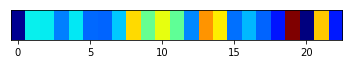

In [13]:
grad = viz_saliency_bar(model, idx,plotting=True, negate=True)

In [14]:
num_show = 20 # len(indices)
grads = [] 
for idx in indices[:num_show]:
    grad = viz_saliency_bar(model, idx,plotting=False,negate=False)
    grads.append(grad)

Text(114.0, 0.5, 'Samples')

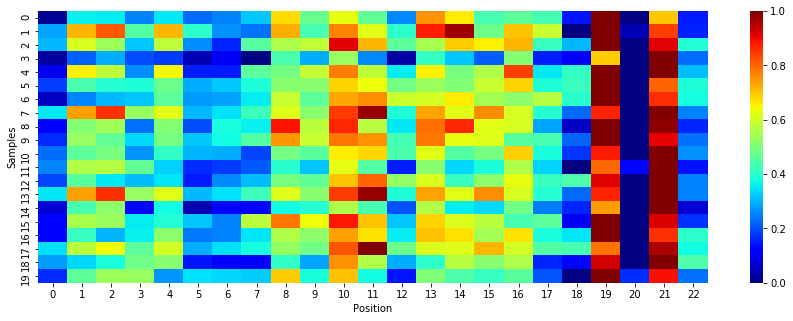

In [15]:
# heatmap over all positive examples' (in test set's) saliency 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap(grads, cmap='jet')
plt.xlabel('Position')
plt.ylabel('Samples')

In [16]:
# average over samples and now plot the original alphabet characters on the y axis, colored by gradient 
# total saliency of each nt per position (then maybe avg)
num_show = 20 # len(indices)
grads_over_letters = {c: np.zeros(seq_len) for c in new_alph}
counts_per_positon = {c: np.zeros(seq_len) for c in new_alph} # so we can normalize by counts at each position
for idx in indices[:num_show]:
    grad = viz_saliency_bar(model, idx,plotting=False,negate=False)
    seq = test_df['Encoded Seqs'][idx]
    for i, grad_i in enumerate(grad): 
        grads_over_letters[seq[i]][i] += grad_i 
        counts_per_positon[seq[i]][i] += 1 

Text(114.0, 0.5, 'Samples')

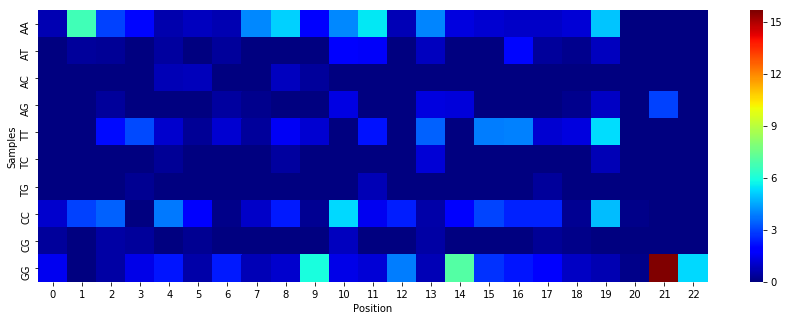

In [17]:
# heatmap over all positive examples' (in test set's) saliency 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap([grads_over_letters[letter] for letter in new_alph], cmap='jet',yticklabels=[reverse_map[letter] for letter in new_alph])
plt.xlabel('Position')
plt.ylabel('Samples')

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(114.0, 0.5, 'Samples')

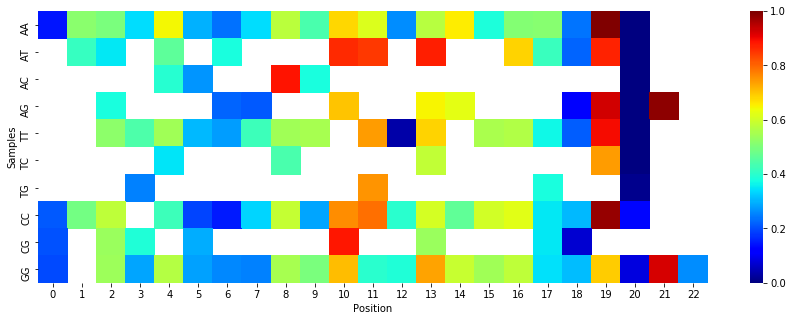

In [18]:
# heatmap over all positive examples' (in test set's) saliency 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap([grads_over_letters[letter]/counts_per_positon[letter] for letter in new_alph], cmap='jet',yticklabels=[reverse_map[letter] for letter in new_alph])
plt.xlabel('Position')
plt.ylabel('Samples')

In [19]:
# look at saliency for true positives and false negatives
grads_tp = []
grads_fn = [] 
for sample_idx, (true_class, pred_class) in enumerate(zip(y_true_labels, y_pred_labels)): 
    if true_class == 1 and pred_class == 1: 
        grad = viz_saliency_bar(model, data_idx=sample_idx,plotting=False)
        grads_tp.append(grad)
    elif true_class == 1 and pred_class == 0: 
        grad = viz_saliency_bar(model, data_idx=sample_idx, class_idx=0,plotting=False)
        grads_fn.append(grad)

Text(0.5, 1.0, 'Saliency Map: True Positives')

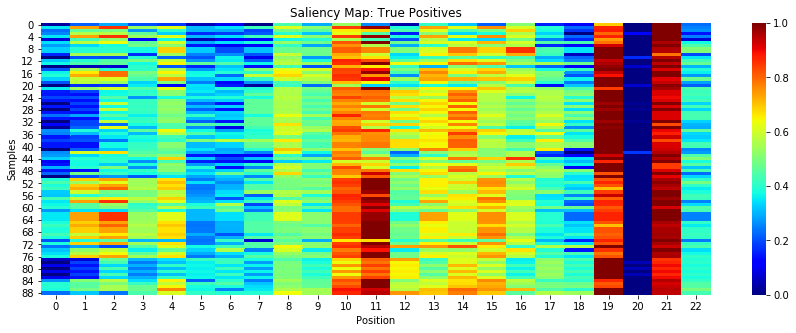

In [20]:
# compare saliency heatmaps for true positive examples and cases where model thought incorreclty that sequence was negative 
 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap(grads_tp, cmap='jet')
plt.xlabel('Position')
plt.ylabel('Samples')
plt.title('Saliency Map: True Positives')

Text(0.5, 1.0, 'Saliency Map: False Negatives')

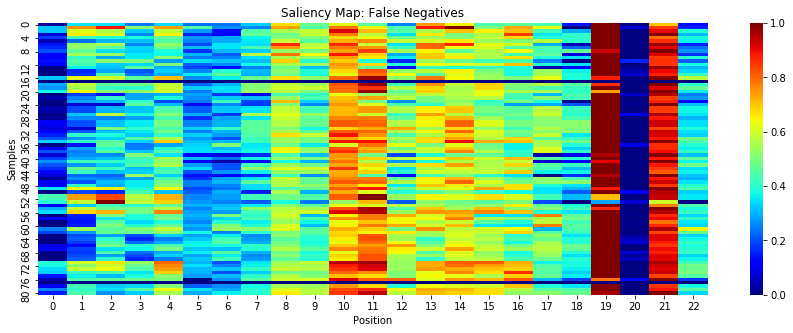

In [21]:
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap(grads_fn, cmap='jet')
plt.xlabel('Position')
plt.ylabel('Samples')
plt.title('Saliency Map: False Negatives')

In [22]:
# average over samples and now plot the original alphabet characters on the y axis, colored by gradient 
# total saliency of each nt per position (then maybe avg)
grads_over_letters_tp = {c: np.zeros(seq_len) for c in new_alph}
counts_per_positon_tp = {c: np.zeros(seq_len) for c in new_alph} # so we can normalize by counts at each position
grads_over_letters_fn = {c: np.zeros(seq_len) for c in new_alph}
counts_per_positon_fn = {c: np.zeros(seq_len) for c in new_alph} # so we can normalize by counts at each position
for sample_idx, (true_class, pred_class) in enumerate(zip(y_true_labels, y_pred_labels)): 
    if true_class == 1 and pred_class == 1: 
        grad = viz_saliency_bar(model, sample_idx,plotting=False,negate=False)
        seq = test_df['Encoded Seqs'][sample_idx]
        for i, grad_i in enumerate(grad): 
            grads_over_letters_tp[seq[i]][i] += grad_i 
            counts_per_positon_tp[seq[i]][i] += 1 
    elif true_class == 1 and pred_class == 0: 
        grad = viz_saliency_bar(model, sample_idx,class_idx=0,plotting=False,negate=False)
        seq = test_df['Encoded Seqs'][sample_idx]
        for i, grad_i in enumerate(grad): 
            grads_over_letters_fn[seq[i]][i] += grad_i 
            counts_per_positon_fn[seq[i]][i] += 1 

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Saliency Map: True Positives')

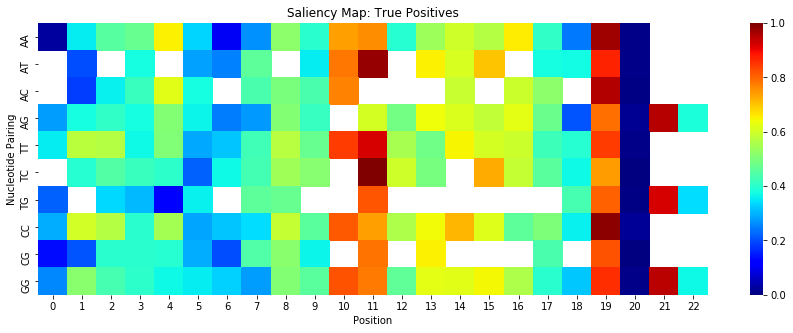

In [23]:
# compare saliency heatmaps for true positive examples and cases where model thought incorreclty that sequence was negative 
 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap([grads_over_letters_tp[letter]/counts_per_positon_tp[letter] for letter in new_alph], cmap='jet',yticklabels=[reverse_map[letter] for letter in new_alph])
plt.xlabel('Position')
plt.ylabel('Nucleotide Pairing')
plt.title('Saliency Map: True Positives')

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Saliency Map: False Negatives')

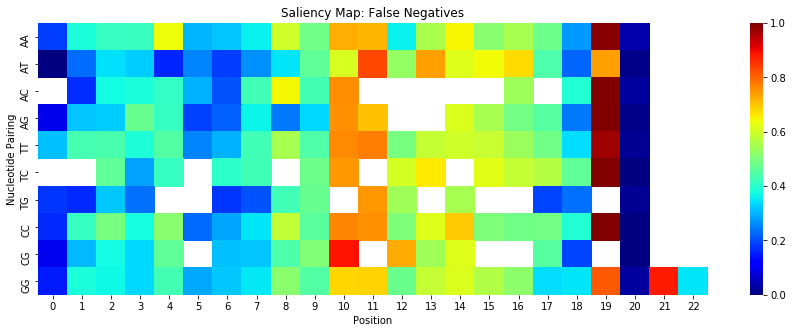

In [24]:
# compare saliency heatmaps for true positive examples and cases where model thought incorreclty that sequence was negative 
 
plt.rcParams["figure.figsize"] = 15,5
sns.heatmap([grads_over_letters_fn[letter]/counts_per_positon_fn[letter] for letter in new_alph], cmap='jet',yticklabels=[reverse_map[letter] for letter in new_alph])
plt.xlabel('Position')
plt.ylabel('Nucleotide Pairing')
plt.title('Saliency Map: False Negatives')

In [25]:
from sklearn.metrics import recall_score, precision_score

print('Recall:', recall_score(y_true_labels, y_pred_labels))
print('Precision:', precision_score(y_true_labels, y_pred_labels))

Recall: 0.5235294117647059
Precision: 0.717741935483871


In [26]:
sample_idx = 70
print('Guide seq: ', test_df['On-Target Site'][sample_idx])
print('Off-target seq:', test_df['Off-Target Site'][sample_idx])
print('Encoded seq: ', test_df['Encoded Seqs'][sample_idx])
print('New alphabet mapping: ', new_alph_map)

Guide seq:  GACCCCCTCCACCCCGCCTCCGG
Off-target seq: GACCCCCTTCACCCCACCTATGG
Encoded seq:  EKPPPPPLMPKPPPPYPPLZMEE
New alphabet mapping:  {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG': 'J', 'CC': 'P', 'CG': 'H', 'GG': 'E'}


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 23, 5)             50        
_________________________________________________________________
flatten_1 (Flatten)          (None, 115)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5800      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
preds (Dense)                (None, 2)                 102       
Total para